In [1]:
from graphchem.datasets import load_cn
from sklearn.model_selection import train_test_split

# load cetane number data
smiles, cn = load_cn()

# create training/testing subsets
smiles_train, smiles_test, cn_train, cn_test = train_test_split(smiles, cn, test_size=0.2, random_state=42)

print(len(smiles_train), len(smiles_test), type(smiles))
print(len(cn_train), len(cn_test), type(cn), cn.shape, '\n')

for i in range(5):

    print(f'{smiles[i]}\t{cn[i]}')

368 92 <class 'list'>
368 92 <class 'torch.Tensor'> torch.Size([460, 1]) 

CC1=CC=C(O1)C(C2=CC=CO2)C3=CC=C(O3)C	tensor([25.5000])
CCCCC1=CC=CO1	tensor([13.1000])
C1CCOCC1	tensor([38.2000])
CC1=CC=C(C)O1	tensor([10.9000])
C1C=CCO1	tensor([15.6000])


In [2]:
from graphchem.data import MoleculeGraph, MoleculeDataset
from graphchem.preprocessing import MoleculeEncoder

# construct encoder using training data
encoder = MoleculeEncoder(smiles_train)

# encode training and test data; each element in form (atom attr, bond attr, connectivity)
encoding_train = encoder.encode_many(smiles_train)
encoding_test = encoder.encode_many(smiles_test)

print('\n', encoding_train[0], '\n')

# construct graphs using encoded data
graphs_train = [MoleculeGraph(e[0], e[1], e[2], cn_train[i]) for i, e in enumerate(encoding_train)]
graphs_test = [MoleculeGraph(e[0], e[1], e[2], cn_test[i]) for i, e in enumerate(encoding_test)]

# construct datasets for training and testing graphs
ds_train = MoleculeDataset(graphs_train)
ds_test = MoleculeDataset(graphs_test)

print(len(ds_train), len(ds_test))


 (tensor([2, 3, 3, 3, 3, 3, 4, 5, 6, 3, 3, 3, 3, 2], dtype=torch.int32), tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2,
        2, 2], dtype=torch.int32), tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  7,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  9,  7,  7,
         10,  9, 11, 10, 12, 11, 13, 12]])) 

368 92


c:\Users\tjkessler\.conda\envs\graphchem\Lib\site-packages\graphchem-2.1.0-py3.11.egg\graphchem\data\structs.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(target).type(torch.float).reshape(1, len(target))


In [3]:
from graphchem.nn import MoleculeGCN
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# prepare training set for training
train_loader = DataLoader(ds_train, batch_size=16, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=1, shuffle=False)

atom_vocab_size, bond_vocab_size = encoder.vocab_sizes

# construct untrained model
model = MoleculeGCN(
    atom_vocab_size,                # number of node/atom features per sample
    bond_vocab_size,                # number of edge/bond features per sample
    1,                              # number of target variables/labels per sample
    embedding_dim=128,              # size of atom/bond embedding
    n_messages=3,                   # number of message-passing ops to perform (>= 1)
    n_readout=3,                    # number of post-graph-operation feed-forward layers (>= 1)
    readout_dim=128,                # number of neurons in each readout layer (>= 1)
    dropout=0.0                     # neuron dropout rate [0.0, 1.0]
)

# construct torch optimizer
lr_decay = 1e-8
init_lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

train_losses = []
test_losses = []

# training loop
model.train()
for epoch in range(400):

    for g in optimizer.param_groups:
        g['lr'] = max(0, init_lr - (epoch * lr_decay))

    train_loss = 0.0
    for batch in train_loader:

        optimizer.zero_grad()
        pred, _, _ = model(batch)
        loss = F.mse_loss(pred, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    test_loss = 0.0
    for batch in test_loader:

        pred, _, _ = model(batch)
        target = batch.y
        loss = F.mse_loss(pred, batch.y)
        test_loss += loss.detach().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    if epoch % 5 == 0:
        print(f'{epoch}: {train_loss}')

# done training
model.eval()

0: 49.57554535243822
5: 25.19924847976021
10: 27.242681524027947
15: 24.52878072987432
20: 18.552562091661535
25: 17.024141643358313
30: 16.06946746162746
35: 14.341543156167734
40: 16.814889285875402
45: 11.754811514978824
50: 10.715770597043244
55: 10.235421823418658
60: 10.56846226816592
65: 8.232471745947134
70: 8.92014885985333
75: 7.110177973042363
80: 7.351929985958597
85: 6.856772884078648
90: 7.353273961855018
95: 5.75025140720865
100: 7.883484591608462
105: 5.373804076858189
110: 5.6871991675833
115: 5.150080183277959
120: 5.2621465869571855
125: 5.565489945204361
130: 5.611542722453242
135: 5.318315785864125
140: 5.104230870371279
145: 4.736013324364372
150: 3.895174337470013
155: 4.047365608422653
160: 6.471494809440944
165: 4.1432661854702495
170: 3.526315207066743
175: 3.0083033805308133
180: 3.7389309147129888
185: 3.2366091686746348
190: 4.018196401388749
195: 3.052056885283926
200: 5.32833805291549
205: 3.747665928757709
210: 2.935333391894465
215: 2.9285237374513047
2

MoleculeGCN(
  (emb_atom): Embedding(42, 128)
  (emb_bond): Embedding(34, 128)
  (atom_conv): GeneralConv(128, 128)
  (bond_conv): EdgeConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
  ))
  (readout): ModuleList(
    (0-2): 3 x Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

<Figure size 640x480 with 0 Axes>

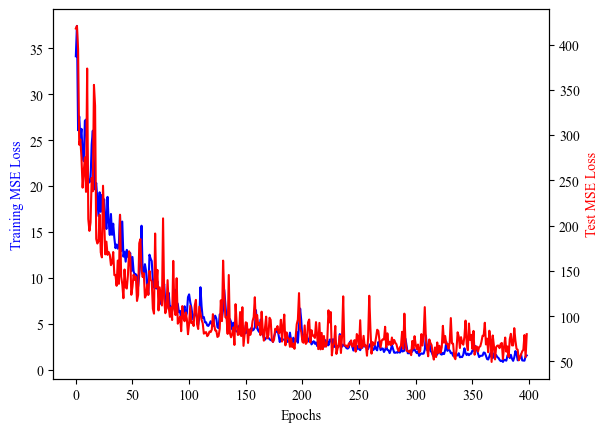

In [4]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots()
ax.plot([i for i in range(len(train_losses[1:]))], train_losses[1:], color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Training MSE Loss', color='blue')
ax2 = ax.twinx()
ax2.plot([i for i in range(len(test_losses[1:]))], test_losses[1:], color='red')
ax2.set_ylabel('Test MSE Loss', color='red')
plt.show()

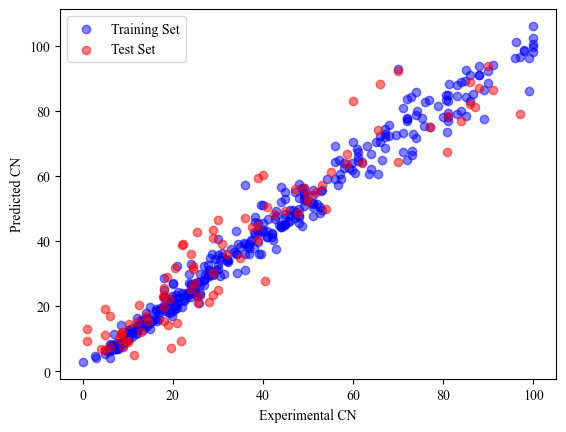

In [5]:
pred_train = [model(mol)[0].detach().numpy() for mol in ds_train]
pred_test = [model(mol)[0].detach().numpy() for mol in ds_test]
exp_train = [mol.y.numpy() for mol in ds_train]
exp_test = [mol.y.numpy() for mol in ds_test]

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.scatter(exp_train, pred_train, color='blue', label='Training Set', alpha=0.5)
plt.scatter(exp_test, pred_test, color='red', label='Test Set', alpha=0.5)
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.legend(loc='upper left')
plt.show()

In [6]:
from sklearn.metrics import median_absolute_error, r2_score

e_test = [e[0] for e in exp_test]
p_test = [p[0] for p in pred_test]

print(f'Test MAE: {median_absolute_error(e_test, p_test)}')
print(f'Test R2: {r2_score(e_test, p_test)}')

Test MAE: 5.428378105163574
Test R2: 0.8749652639665292
